# Detection and Recognition using trained models

In [1]:
# Install dependencies
!pip install torch torchvision easyocr numpy opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 13.0 MB/s eta 0:00:00


In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import easyocr
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import imutils
from ultralytics import YOLO
import re
import zipfile
import os
import pandas as pd



In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Importing the trained models for detection and recognistion

In [ ]:
# Load YOLOv5 Detection Model
model = YOLO("/content/best.pt")  # Path to your trained model

class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.rnn = nn.LSTM(64*16, 128, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 3, 2, 1).contiguous().view(x.size(0), x.size(1), -1)
        x, _ = self.rnn(x)
        return self.fc(x)

# Load CRNN Model
crnn_model = CRNN(num_classes=37)  # 0-9, A-Z, and blank for CTC
crnn_model.load_state_dict(torch.load("/content/custom_crnn.pth", map_location=torch.device('cpu')))
crnn_model.eval()



CRNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=37, bias=True)
)

In [ ]:
reader = easyocr.Reader(['en'], gpu=True)

we are using it to Convert an image to grayscale and applies either Otsu thresholding or edge detection for plate preprocessing.

In [ ]:
def preprocess_plate(plate_img, method="otsu"):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    if method == "otsu":
        _, processed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
        processed = cv2.Canny(bfilter, 30, 200)

    return processed

To extract only numbers from OCR-detected text after preprocessing the plate image.

In [ ]:
def clean_plate_text(text):
    return re.sub(r'[^0-9]', '', text)  # Keep only numbers

def recognize_plate_easyocr(plate_img, method="otsu"):
    processed_img = preprocess_plate(plate_img, method)
    results = reader.readtext(processed_img, detail=0)  # Only get text

    recognized_text = ''.join([clean_plate_text(text) for text in results if clean_plate_text(text)])
    return recognized_text

It modifies the plate number by replacing specific characters with "T" based on length to replace the misread urdu characters in the number plate

In [ ]:
def process_plate_number(plate_text):
    length = len(plate_text)

    if 6 <= length <= 7:
        index_to_replace = length - 5
        plate_text = plate_text[:index_to_replace] + "T" + plate_text[index_to_replace + 1:]

    elif length >= 8:
        plate_text = plate_text[:3] + "T" + plate_text[-4:]

    return plate_text

Detects license plates using YOLO, recognizes text with EasyOCR, processes the number, and displays results on the image.


0: 640x480 1 License_Plate, 172.3ms
Speed: 4.1ms preprocess, 172.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
🔹 Final Plate Number: 169T9685


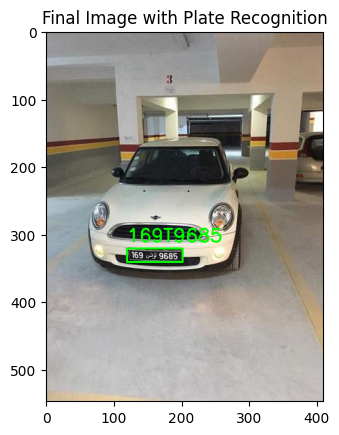

In [8]:
def detect_and_recognize(image_path):
    img = cv2.imread(image_path)
    results = model(img)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_img = img[y1:y2, x1:x2]

            # Try Otsu first
            plate_text = recognize_plate_easyocr(plate_img, method="otsu")

            # Retry if the length is less than 6
            if not plate_text or len(plate_text) < 6:
                plate_text = recognize_plate_easyocr(plate_img, method="edges")

            # Process final plate number after retrying
            if plate_text:
                plate_text = process_plate_number(plate_text)

            print(f"🔹 Final Plate Number: {plate_text}")

            # Draw bounding box and text
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, plate_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Final Image with Plate Recognition")
    plt.show()

# Run detection and recognition
detect_and_recognize("/content/901.jpg")


In [11]:
zip_files = ['/content/drive/My Drive/Task/test.zip']

for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_path = os.path.join('/content', os.path.basename(zip_path).replace('.zip', ''))
        zip_ref.extractall(extract_path)


Similar detect_and_recognize function but used on the test folder

In [23]:
def detect_and_recognize_all(test_folder):
    results_list = []

    for img_name in os.listdir(test_folder):
        img_path = os.path.join(test_folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue  # Skip if the image cannot be loaded

        results = model(img)

        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                plate_img = img[y1:y2, x1:x2]

                # Try Otsu first
                plate_text = recognize_plate_easyocr(plate_img, method="otsu")

                # Retry if the length is less than 6
                if not plate_text or len(plate_text) < 6:
                    plate_text = recognize_plate_easyocr(plate_img, method="edges")

                # Process final plate number
                if plate_text:
                    plate_text = process_plate_number(plate_text)

                results_list.append({"img_id": img_name, "plate_number": plate_text})

                # Draw bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, plate_text, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Uncomment to visualize results
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # plt.title(f"Processed: {img_name}")
        # plt.show()

    # Convert to DataFrame
    df = pd.DataFrame(results_list)
    df.to_csv("/content/recognized_plates.csv", index=False)
    print("Results saved to recognized_plates.csv")


In [24]:
# Run on all images in test folder
test_folder = "/content/test/test/test"
detect_and_recognize_all(test_folder)


0: 480x640 1 License_Plate, 214.0ms
Speed: 7.1ms preprocess, 214.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 License_Plate, 429.1ms
Speed: 5.0ms preprocess, 429.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 License_Plate, 173.8ms
Speed: 4.2ms preprocess, 173.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 License_Plate, 166.2ms
Speed: 4.9ms preprocess, 166.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 License_Plate, 174.2ms
Speed: 4.5ms preprocess, 174.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 License_Plate, 147.3ms
Speed: 4.3ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 License_Plate, 238.7ms
Speed: 4.5ms preprocess, 238.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 License_Plate, 223.9ms
Speed: 4.4ms prepr

In [28]:
df = pd.read_csv("/content/recognized_plates.csv")
print(df.head())

     img_id plate_number
0   939.jpg       8T8179
1   946.jpg     416T9170
2   960.jpg      04T4280
3   941.jpg       8T2488
4  1056.jpg     167T5257
